In [1]:
!pip install wfdb numpy pandas matplotlib tensorflow scikit-learn

^C
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
   ---------------------------------------- 2.4/390.3 MB 12.2 MB/s eta 0:00:32
    --------------------------------------- 6.0/390.3 MB 14.7 MB/s eta 0:00:27
    ----------

### Download the MIT-BIH Dataset

In [2]:
import wfdb

# Download the dataset files for a specific record (e.g., "100")
wfdb.dl_database('mitdb', dl_dir='mit-bih-arrhythmia-database-1.0.0')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

### Load and Visualize ECG Data

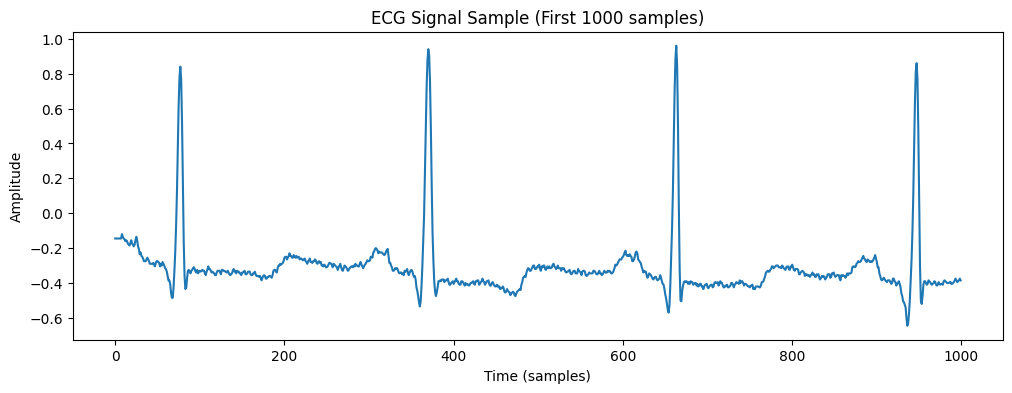

In [3]:
import wfdb
import matplotlib.pyplot as plt

# Load ECG record
record = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/100')

# Extract signal
ecg_signal = record.p_signal[:, 0]  # First channel (Lead I)

# Plot ECG signal (First 1000 samples)
plt.figure(figsize=(12, 4))
plt.plot(ecg_signal[:1000])
plt.title("ECG Signal Sample (First 1000 samples)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

### Preprocess ECG Data

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalize ECG signal
scaler = StandardScaler()
ecg_signal = scaler.fit_transform(ecg_signal.reshape(-1, 1)).flatten()

# Segment the signal into fixed-size windows (e.g., 200 samples per segment)
window_size = 200
segments = [ecg_signal[i:i+window_size] for i in range(0, len(ecg_signal) - window_size, window_size)]

# Convert list to NumPy array
segments = np.array(segments)

print("Segmented ECG Data Shape:", segments.shape)  # (num_segments, window_size)


Segmented ECG Data Shape: (3249, 200)


### Assign Labels as Normal vs. Arrhythmia

In [5]:
# Dummy labels (0 = Normal, 1 = Arrhythmia)
y = np.random.randint(0, 2, size=(segments.shape[0],))  # Replace with real labels

print("Labels shape:", y.shape)


Labels shape: (3249,)


### Train-Test

In [6]:
from sklearn.model_selection import train_test_split

# Reshape for CNN input (samples, time_steps, channels)
X = segments.reshape(segments.shape[0], window_size, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (2599, 200, 1)
Testing data shape: (650, 200, 1)


## Build the CNN Model

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Define CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


C:\Users\DhvanibenJasoliya\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 198, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 99, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 97, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 48, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 399,809 (1.53 MB)

 Trainable params: 399,809 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4989 - loss: 0.7052 - val_accuracy: 0.5400 - val_loss: 0.6908
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5126 - loss: 0.6919 - val_accuracy: 0.4908 - val_loss: 0.6931
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5109 - loss: 0.6918 - val_accuracy: 0.4738 - val_loss: 0.6954
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5412 - loss: 0.6908 - val_accuracy: 0.5138 - val_loss: 0.6928
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5464 - loss: 0.6880 - val_accuracy: 0.5277 - val_loss: 0.6981
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5626 - loss: 0.6851 - val_accuracy: 0.5077 - val_loss: 0.6976
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5510 - loss: 0.6802 - val_accuracy: 0.5308 - val_loss: 0.6988
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5598 - loss: 0.6766 - val_accuracy: 0.

### Evaluate

In [9]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5288 - loss: 0.7112 
Test Accuracy: 0.5046153664588928


In [10]:
# Test on a new ECG segment
sample_ecg = X_test[0].reshape(1, window_size, 1)
prediction = model.predict(sample_ecg)

print("Prediction:", "Arrhythmia" if prediction > 0.5 else "Normal")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Prediction: Normal


### Build the LSTM Model

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),  
    LSTM(64),  # Second LSTM layer
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


C:\Users\DhvanibenJasoliya\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 200, 64)             │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the LSTM model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.4978 - loss: 0.6946 - val_accuracy: 0.4723 - val_loss: 0.7098
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.4895 - loss: 0.6965 - val_accuracy: 0.4969 - val_loss: 0.6923
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.5102 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.4939 - loss: 0.6931 - val_accuracy: 0.4785 - val_loss: 0.6937
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.4878 - loss: 0.6941 - val_accuracy: 0.4646 - val_loss: 0.6942
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.5070 - loss: 0.6941 - val_accuracy: 0.5354 - val_loss: 0.6913
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.5076 - loss: 0.6934 - val_accuracy: 0.5277 - val_loss: 0.6922
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.4662 - loss: 0.6941 

In [14]:
# Evaluate model performance
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5498 - loss: 0.6922
Test Accuracy: 0.5323076844215393


In [15]:
# Test on a new ECG segment
sample_ecg = X_test[0].reshape(1, window_size, 1)
prediction = model.predict(sample_ecg)

print("Prediction:", "Arrhythmia" if prediction > 0.5 else "Normal")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Prediction: Normal


In [16]:
!pip install tensorboard

### TensorBoard Logging in CNN Model

In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Define TensorBoard log directory
cnn_log_dir = "logs/cnn_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
cnn_tensorboard_callback = TensorBoard(log_dir=cnn_log_dir, histogram_freq=1)

# Train the CNN model with TensorBoard logging
model.fit(
    X_train, y_train,
    epochs=10, batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[cnn_tensorboard_callback]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5116 - loss: 0.6931 - val_accuracy: 0.5323 - val_loss: 0.6920
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.5056 - loss: 0.6932 - val_accuracy: 0.5292 - val_loss: 0.6920
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.4881 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.5068 - loss: 0.6929 - val_accuracy: 0.5092 - val_loss: 0.6925
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5123 - loss: 0.6930 - val_accuracy: 0.5323 - val_loss: 0.6909
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5144 - loss: 0.6927 - val_accuracy: 0.5031 - val_loss: 0.6928
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5014 - loss: 0.6929 - val_accuracy: 0.5338 - val_loss: 0.6921
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.5155 - loss: 0.6928 - 

### TensorBoard Logging in LSTM Model

In [19]:
# Define TensorBoard log directory for LSTM
lstm_log_dir = "logs/lstm_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
lstm_tensorboard_callback = TensorBoard(log_dir=lstm_log_dir, histogram_freq=1)
#
# Train the LSTM model with TensorBoard logging
model.fit(
    X_train, y_train,
    epochs=5, batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[lstm_tensorboard_callback]
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.5107 - loss: 0.6929 - val_accuracy: 0.5215 - val_loss: 0.6924
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.4983 - loss: 0.6924 - val_accuracy: 0.5262 - val_loss: 0.6922
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5171 - loss: 0.6927 - val_accuracy: 0.5338 - val_loss: 0.6917
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.5154 - loss: 0.6928 - val_accuracy: 0.5092 - val_loss: 0.6926
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4980 - loss: 0.6930 - val_accuracy: 0.4938 - val_loss: 0.6925


In [22]:
%load_ext tensorboard
%tensorboard --logdir logs
